In [341]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import TanimotoSimilarity
import matplotlib.pyplot as plt
from matplotlib import font_manager
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
import seaborn as sns
import pickle
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV


### Data Preprocessing - Labels

In [120]:
# load no interactions data (negative samples)
# no_interactions_file = "/Users/asmakhimani/Downloads/no_interaction_pairs_otc_only.csv"
no_interactions_file = "/Users/asmakhimani/Downloads/no_interaction_pairs.csv"
df_negative = pd.read_csv(no_interactions_file)

In [121]:
# add a label column for negative samples
df_negative['label'] = 0
print(df_negative.head())

  Drug_ID_1          Drug_Name_1 Drug_ID_2          Drug_Name_2  label
0   DB00001            Lepirudin   DB00002            Cetuximab      0
1   DB00002            Cetuximab   DB00003         Dornase alfa      0
2   DB00003         Dornase alfa   DB00004  Denileukin diftitox      0
3   DB00004  Denileukin diftitox   DB00005           Etanercept      0
4   DB00005           Etanercept   DB00006          Bivalirudin      0


In [122]:
# load interactions data (positive samples)
# interactions_file = "/Users/asmakhimani/Downloads/filtered_extract_list_both.csv"
interactions_file = "/Users/asmakhimani/Downloads/extract_list_final.csv"
df_positive = pd.read_csv(interactions_file)

In [123]:
# add a label column for positive samples
df_positive['label'] = 1
print(df_positive.head())

    dg_id1   dg_name1   dg_id2              dg_name2  \
0  DB00001  Lepirudin  DB06605              Apixaban   
1  DB00001  Lepirudin  DB06695  Dabigatran etexilate   
2  DB00001  Lepirudin  DB01254             Dasatinib   
3  DB00001  Lepirudin  DB01609           Deferasirox   
4  DB00001  Lepirudin  DB01586  Ursodeoxycholic acid   

                                         Description  label  
0  Apixaban may increase the anticoagulant activi...      1  
1  Dabigatran etexilate may increase the anticoag...      1  
2  The risk or severity of bleeding and hemorrhag...      1  
3  The risk or severity of gastrointestinal bleed...      1  
4  The risk or severity of bleeding and bruising ...      1  


In [124]:
# standardize column names
df_positive.rename(columns={
    'dg_id1': 'Drug_ID_1',
    'dg_name1': 'Drug_Name_1',
    'dg_id2': 'Drug_ID_2',
    'dg_name2': 'Drug_Name_2',
    'Description': 'Description'
}, inplace=True)

# add missing columns (description column to df_negative)
df_negative['Description'] = None

print(df_negative.head())
print(df_positive.head())

  Drug_ID_1          Drug_Name_1 Drug_ID_2          Drug_Name_2  label  \
0   DB00001            Lepirudin   DB00002            Cetuximab      0   
1   DB00002            Cetuximab   DB00003         Dornase alfa      0   
2   DB00003         Dornase alfa   DB00004  Denileukin diftitox      0   
3   DB00004  Denileukin diftitox   DB00005           Etanercept      0   
4   DB00005           Etanercept   DB00006          Bivalirudin      0   

  Description  
0        None  
1        None  
2        None  
3        None  
4        None  
  Drug_ID_1 Drug_Name_1 Drug_ID_2           Drug_Name_2  \
0   DB00001   Lepirudin   DB06605              Apixaban   
1   DB00001   Lepirudin   DB06695  Dabigatran etexilate   
2   DB00001   Lepirudin   DB01254             Dasatinib   
3   DB00001   Lepirudin   DB01609           Deferasirox   
4   DB00001   Lepirudin   DB01586  Ursodeoxycholic acid   

                                         Description  label  
0  Apixaban may increase the anticoagulant

In [125]:
# combine the datasets
df_combined = pd.concat([df_positive, df_negative], axis=0).reset_index(drop=True)
print(df_combined.head())

  Drug_ID_1 Drug_Name_1 Drug_ID_2           Drug_Name_2  \
0   DB00001   Lepirudin   DB06605              Apixaban   
1   DB00001   Lepirudin   DB06695  Dabigatran etexilate   
2   DB00001   Lepirudin   DB01254             Dasatinib   
3   DB00001   Lepirudin   DB01609           Deferasirox   
4   DB00001   Lepirudin   DB01586  Ursodeoxycholic acid   

                                         Description  label  
0  Apixaban may increase the anticoagulant activi...      1  
1  Dabigatran etexilate may increase the anticoag...      1  
2  The risk or severity of bleeding and hemorrhag...      1  
3  The risk or severity of gastrointestinal bleed...      1  
4  The risk or severity of bleeding and bruising ...      1  


In [126]:
# check how many positive and negative cases 
print(df_combined['label'].value_counts())

label
1    8213629
0      15938
Name: count, dtype: int64


## Feature Engineering

### Getting SMILES codes for each Drug

In [127]:
# load the file with drug ids and smiles codes
drug_smiles = pd.read_csv("/Users/asmakhimani/Downloads/drugs_init_and_smiles.csv")

# create a dictionary for smiles lookup
smiles_lookup_by_id = dict(zip(drug_smiles['ID'], drug_smiles['SMILES']))
smiles_lookup_by_name = dict(zip(drug_smiles['Name'], drug_smiles['SMILES']))

In [128]:
# map smiles codes for drug pairs in the positive dataset
df_positive['SMILES_1'] = df_positive['Drug_ID_1'].map(smiles_lookup_by_id)
df_positive['SMILES_2'] = df_positive['Drug_ID_2'].map(smiles_lookup_by_id)

# if id mapping fails, try mapping by names as another option
df_positive['SMILES_1'] = df_positive['SMILES_1'].fillna(df_positive['Drug_Name_1'].map(smiles_lookup_by_name))
df_positive['SMILES_2'] = df_positive['SMILES_2'].fillna(df_positive['Drug_Name_2'].map(smiles_lookup_by_name))

# map smiles codes for drug pairs in the negative dataset
df_negative['SMILES_1'] = df_negative['Drug_ID_1'].map(smiles_lookup_by_id)
df_negative['SMILES_2'] = df_negative['Drug_ID_2'].map(smiles_lookup_by_id)

# if id mapping fails, try mapping by names as another option
df_negative['SMILES_1'] = df_negative['SMILES_1'].fillna(df_negative['Drug_Name_1'].map(smiles_lookup_by_name))
df_negative['SMILES_2'] = df_negative['SMILES_2'].fillna(df_negative['Drug_Name_2'].map(smiles_lookup_by_name))

In [129]:
# find rows with missing smiles codes
missing_smiles_positive = df_positive[df_positive['SMILES_1'].isnull() | df_positive['SMILES_2'].isnull()]
missing_smiles_negative = df_negative[df_negative['SMILES_1'].isnull() | df_negative['SMILES_2'].isnull()]

# Print the number of missing smiles codes
print(f"missing smiles in positive dataset: {len(missing_smiles_positive)}")
print(f"missing smiles in negative dataset: {len(missing_smiles_negative)}")

missing smiles in positive dataset: 1011710
missing smiles in negative dataset: 5905


In [130]:
# Drop rows with missing SMILES codes
df_positive = df_positive.dropna(subset=['SMILES_1', 'SMILES_2'])
df_negative = df_negative.dropna(subset=['SMILES_1', 'SMILES_2'])

In [131]:
# check a few rows
print(df_positive.head())
print(df_negative.head())

      Drug_ID_1  Drug_Name_1 Drug_ID_2           Drug_Name_2  \
13195   DB00006  Bivalirudin   DB06605              Apixaban   
13196   DB00006  Bivalirudin   DB06695  Dabigatran etexilate   
13197   DB00006  Bivalirudin   DB01254             Dasatinib   
13198   DB00006  Bivalirudin   DB01609           Deferasirox   
13199   DB00006  Bivalirudin   DB01586  Ursodeoxycholic acid   

                                             Description  label  \
13195  Apixaban may increase the anticoagulant activi...      1   
13196  Dabigatran etexilate may increase the anticoag...      1   
13197  The risk or severity of bleeding and hemorrhag...      1   
13198  The risk or severity of gastrointestinal bleed...      1   
13199  The risk or severity of bleeding and bruising ...      1   

                                                SMILES_1  \
13195  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...   
13196  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...   
13197  CC[C@H](C)[C@H](NC(=O)[C@

In [132]:
# check that there are no missing smiles codes after processing
print("Missing SMILES in positive dataset:", df_positive.isnull().sum())
print("Missing SMILES in negative dataset:", df_negative.isnull().sum())

Missing SMILES in positive dataset: Drug_ID_1      0
Drug_Name_1    0
Drug_ID_2      0
Drug_Name_2    0
Description    0
label          0
SMILES_1       0
SMILES_2       0
dtype: int64
Missing SMILES in negative dataset: Drug_ID_1          0
Drug_Name_1        0
Drug_ID_2          0
Drug_Name_2        0
label              0
Description    10033
SMILES_1           0
SMILES_2           0
dtype: int64


In [133]:
# confirm the shape of the datasets
print(f"Number of rows in positive dataset: {len(df_positive)}")
print(f"Number of rows in negative dataset: {len(df_negative)}")

Number of rows in positive dataset: 7201919
Number of rows in negative dataset: 10033


### Getting Samples Subset (100k)

In [96]:
# Define desired sample sizes
negative_sample_size = len(df_negative)  # Use all negative samples (10,033)
positive_sample_size = 100000 - negative_sample_size  # Remaining rows for positive samples (89,967)

In [97]:
# Sample from the positive dataset
df_positive_sample = df_positive.sample(n=positive_sample_size, random_state=42)

# Combine positive and negative samples
df_combined = pd.concat([df_positive_sample, df_negative])

# Shuffle the dataset
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm the shape
print(f"Total samples in combined dataset: {len(df_combined)}")

Total samples in combined dataset: 100000


In [85]:
# Split into two halves
split_size = len(df_combined) // 2
df_part1 = df_combined.iloc[:split_size]
df_part2 = df_combined.iloc[split_size:]

# Save to CSV files
df_part1.to_csv("subset_part1.csv", index=False)
df_part2.to_csv("subset_part2.csv", index=False)

print("Datasets saved:")
print(f"Part 1: {len(df_part1)} rows -> subset_part1.csv")
print(f"Part 2: {len(df_part2)} rows -> subset_part2.csv")

Datasets saved:
Part 1: 50000 rows -> subset_part1.csv
Part 2: 50000 rows -> subset_part2.csv


### Calculating Chemical Similarity

In [134]:
# function to generate fingerprints
def get_fingerprint(smiles):
    if pd.notna(smiles):  # Check if SMILES is not NaN
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return None

# # apply to both datasets
# df_positive['Fingerprint_1'] = df_positive['SMILES_1'].apply(get_fingerprint)
# df_positive['Fingerprint_2'] = df_positive['SMILES_2'].apply(get_fingerprint)

# df_negative['Fingerprint_1'] = df_negative['SMILES_1'].apply(get_fingerprint)
# df_negative['Fingerprint_2'] = df_negative['SMILES_2'].apply(get_fingerprint)

In [135]:
# load the subset csv file
df_subset = pd.read_csv("subset_part1.csv")

In [136]:
# use tqdm progress bar for fingerprint generation
tqdm.pandas(desc="Generating Fingerprints")

# Generate fingerprints for SMILES_1 and SMILES_2 columns
df_subset['Fingerprint_1'] = df_subset['SMILES_1'].progress_apply(get_fingerprint)
df_subset['Fingerprint_2'] = df_subset['SMILES_2'].progress_apply(get_fingerprint)

# save the updated dataset
df_subset.to_pickle("subset_part1_with_fingerprints.pkl")  # save as a pickle to preserve fingerprint objects
print("Fingerprint generation completed and saved to 'subset_part1_with_fingerprints.pkl'")

Generating Fingerprints: 100%|██████████| 50000/50000 [00:05<00:00, 9689.52it/s]


Fingerprint generation completed and saved to 'subset_part1_with_fingerprints.pkl'


In [137]:
# function to compute tanimoto similarity
def compute_similarity(fp1, fp2):
    if fp1 is not None and fp2 is not None:
        return TanimotoSimilarity(fp1, fp2)
    return 0  # return 0 if any fingerprint is missing

tqdm.pandas(desc="Computing Tanimoto Similarity")

# apply to subset file
df_subset['Similarity'] = df_subset.progress_apply(
    lambda x: compute_similarity(x['Fingerprint_1'], x['Fingerprint_2']), axis=1
)


Computing Tanimoto Similarity: 100%|██████████| 50000/50000 [00:00<00:00, 214165.12it/s]


In [142]:
# check the first few rows of df_subset
#print(df_subset[['Fingerprint_1', 'Fingerprint_2', 'Similarity']].head())
df_subset = df_subset.drop_duplicates(["Drug_Name_1", "Drug_Name_2"])
print(len(df_subset))
df_subset.to_csv("subset_with_tan_sim.csv")
df_subset.head()

47935


,Drug_ID_1,Drug_Name_1,Drug_ID_2,Drug_Name_2,Description,label,SMILES_1,SMILES_2,Fingerprint_1,Fingerprint_2,Similarity
0,DB09130,Copper,DB15335,Formononetin,Formononetin can cause an increase in the abso...,1,[Cu],COc1ccc(-c2coc3cc(O)ccc3c2=O)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
1,DB00939,Meclofenamic acid,DB00582,Voriconazole,The serum concentration of Meclofenamic acid c...,1,Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl,C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.064103
2,DB11362,Selexipag,DB00669,Sumatriptan,Sumatriptan may decrease the antihypertensive ...,1,CC(C)N(CCCCOCC(=O)NS(C)(=O)=O)c1cnc(-c2ccccc2)...,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.146341
3,DB00363,Clozapine,DB12890,Dihydrexidine,The therapeutic efficacy of Dihydrexidine can ...,1,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Oc1cc2c(cc1O)[C@@H]1c3ccccc3CN[C@H]1CC2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.151515
4,DB03847,gamma-carboxy-L-glutamic acid,DB03848,Benzenesulfinic acid,NaN,0,N[C@@H](CC(C(=O)O)C(=O)O)C(=O)O,O=[S@](O)c1ccccc1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.103448


In [143]:
# check for missing similarity scores in subset
missing_similarity = df_subset['Similarity'].isnull().sum()
print(f"Missing similarity scores in df_subset: {missing_similarity}")

Missing similarity scores in df_subset: 0


In [144]:
# Summary statistics for the entire testing subset
print("Overall similarity stats:")
print(df_subset['Similarity'].describe())

# Separate stats for negative samples (Label = 0)
negative_samples = df_subset[df_subset['label'] == 0]
print("\nNegative samples similarity stats (label = 0):")
print(negative_samples['Similarity'].describe())

# Separate stats for positive samples (Label = 1)
positive_samples = df_subset[df_subset['label'] == 1]
print("\nPositive samples similarity stats (label = 1):")
print(positive_samples['Similarity'].describe())

Overall similarity stats:
count    47935.000000
mean         0.103816
std          0.065714
min          0.000000
25%          0.069444
50%          0.096774
75%          0.127273
max          1.000000
Name: Similarity, dtype: float64

Negative samples similarity stats (label = 0):
count    5038.000000
mean        0.116421
std         0.119530
min         0.000000
25%         0.063291
50%         0.092784
75%         0.127273
max         1.000000
Name: Similarity, dtype: float64

Positive samples similarity stats (label = 1):
count    42897.000000
mean         0.102335
std          0.055919
min          0.000000
25%          0.070175
50%          0.097222
75%          0.127273
max          0.867647
Name: Similarity, dtype: float64


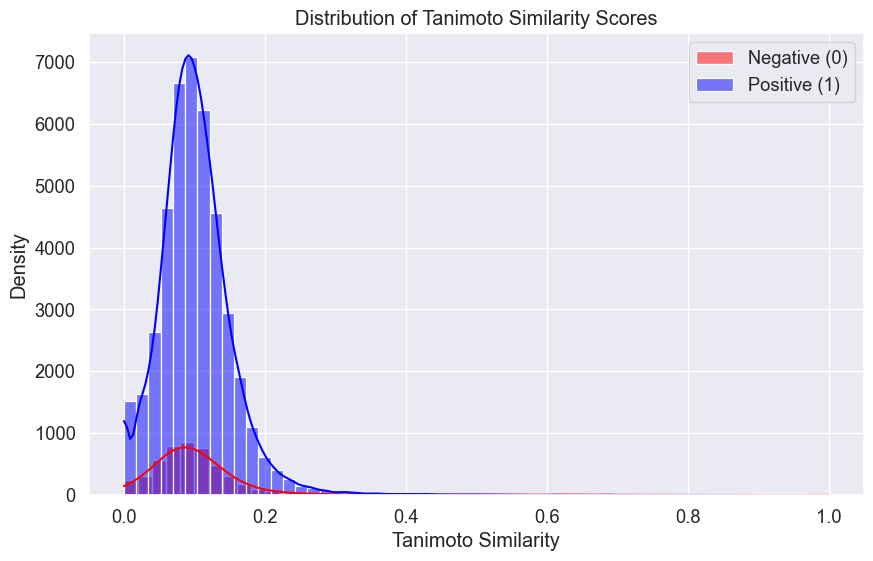

In [690]:
# plt.hist(df_positive['Similarity'], bins=20, alpha=0.7, label='Positive')
# plt.hist(df_negative['Similarity'], bins=20, alpha=0.7, label='Negative')
# plt.xlabel('Tanimoto Similarity')
# plt.ylabel('Frequency')
# plt.legend()
# plt.title('Distribution of Similarity Scores')
# plt.show()

# plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(negative_samples['Similarity'], bins=50, kde=True, color='red', label='Negative (0)', alpha=0.5)
sns.histplot(positive_samples['Similarity'], bins=50, kde=True, color='blue', label='Positive (1)', alpha=0.5)

# labels and legend
plt.title('Distribution of Tanimoto Similarity Scores')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Density')
plt.legend()
plt.savefig('tc_plot.png')
plt.show()

### Extracting FAERs Data 

In [42]:
# Extract the next 1000 pairs
df_next_1000 = df_subset.iloc[5500:6500]
subset_pairs = list(zip(df_next_1000['Drug_Name_1'], df_next_1000['Drug_Name_2']))
df_next_1000.head()

,Drug_ID_1,Drug_Name_1,Drug_ID_2,Drug_Name_2,Description,label,SMILES_1,SMILES_2,Fingerprint_1,Fingerprint_2,Similarity
5500,DB12010,Fostamatinib,DB06817,Raltegravir,The metabolism of Raltegravir can be decreased...,1,COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)N(COP(=O)(O)O)C(...,Cc1nnc(C(=O)NC(C)(C)c2nc(C(=O)NCc3ccc(F)cc3)c(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.174312
5501,DB06246,Exisulind,DB06742,Ambroxol,The risk or severity of methemoglobinemia can ...,1,CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C\c1ccc(S(C)(=O)=...,Nc1c(Br)cc(Br)cc1CN[C@H]1CC[C@H](O)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.068493
5502,DB00214,Torasemide,DB08906,Fluticasone furoate,The risk or severity of hypokalemia can be inc...,1,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.092593
5503,DB04665,Coumarin,DB00256,Lymecycline,Lymecycline may increase the anticoagulant act...,1,O=c1ccc2ccccc2o1,CN(C)[C@@H]1C(O)=C(C(=O)NCNCCCC[C@H](N)C(=O)O)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.065934
5504,DB01029,Irbesartan,DB00668,Epinephrine,The metabolism of Irbesartan can be decreased ...,1,CCCCC1=NC2(CCCC2)C(=O)N1Cc1ccc(-c2ccccc2-c2nn[...,CNC[C@H](O)c1ccc(O)c(O)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.064935


In [43]:
# query faers api
def query_faers(pair):
    drug1, drug2 = pair
    query = f"patient.drug.medicinalproduct:{drug1}+AND+{drug2}"
    params = {"search": query, "limit": 200}
    try:
        response = requests.get("https://api.fda.gov/drug/event.json", params=params, timeout=10)
        if response.status_code == 200:
            return {"pair": pair, "data": response.json()}
    except requests.exceptions.RequestException as e:
        print(f"Error querying pair {pair}: {e}")
    return {"pair": pair, "data": None}

# # process the drug pairs
# subset_results = []
# for pair in tqdm(subset_pairs, desc="Querying FAERS"):
#     result = query_faers(pair)
#     subset_results.append(result)

# parallel execution for FAERS queries
print("Querying FAERS API for drug pairs in parallel...")
with ThreadPoolExecutor(max_workers=20) as executor:
    # Use tqdm to track progress
    subset_results = list(tqdm(executor.map(query_faers, subset_pairs), total=len(subset_pairs), desc="Querying FAERS"))
    
print("FAERS API queries completed.")

Querying FAERS API for drug pairs in parallel...


Querying FAERS:  84%|████████▍ | 843/1000 [05:00<00:15, 10.45it/s]

Error querying pair ('Paromomycin', 'Isradipine'): HTTPSConnectionPool(host='api.fda.gov', port=443): Read timed out. (read timeout=10)Error querying pair ('Zinc', 'Phenobarbital'): HTTPSConnectionPool(host='api.fda.gov', port=443): Read timed out. (read timeout=10)

Error querying pair ('Sitagliptin', 'Tolfenamic acid'): HTTPSConnectionPool(host='api.fda.gov', port=443): Read timed out. (read timeout=10)


Querying FAERS: 100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


FAERS API queries completed.


In [44]:
# get features from faers data
def extract_features(faers_data):
    frequency_count = 0
    severity_score = 0
    if faers_data and 'results' in faers_data:
        for event in faers_data['results']:
            drugs = event.get("patient", {}).get("drug", [])
            # only process reports with <= 3 drugs
            if len(drugs) <= 3:
                frequency_count += 1

                seriousness = {
                    "hospitalization": event.get("seriousnesshospitalization"),
                    "disability": event.get("seriousnessdisabling"),
                    "life_threatening": event.get("seriousnesslifethreatening"),
                    "death": event.get("seriousnessdeath")
                }
                # print(f"Seriousness fields for event: {seriousness}")

                # calculate severity score
                severity_score += (
                    (int(seriousness.get("hospitalization") or 0) * 1) +
                    (int(seriousness.get("disability") or 0) * 2) +
                    (int(seriousness.get("life_threatening") or 0) * 3) +
                    (int(seriousness.get("death") or 0) * 5)
                )
    return frequency_count, severity_score

# process results
subset_features = []
print("Processing FAERS results...")
for result in tqdm(subset_results, desc="Processing FAERS results"):
    pair = result['pair']
    faers_data = result['data']
    freq, severity = extract_features(faers_data)
    subset_features.append({"Drug_Name_1": pair[0], "Drug_Name_2": pair[1],
                            "Adverse_Event_Frequency": freq, "Severity_Score": severity})

# convert to df
df_subset_features = pd.DataFrame(subset_features)
print("Subset Features:")
print(df_subset_features)

# save the features to csv
df_subset_features.to_csv("faers_features_with_scores_5500_6500.csv", index=False)
print("FAERS features saved to 'faers_features_with_scores_5500_6500.csv'")

Processing FAERS results...


Processing FAERS results: 100%|██████████| 1000/1000 [00:00<00:00, 1998.96it/s]

Subset Features:
                                       Drug_Name_1  \
0                                     Fostamatinib   
1                                        Exisulind   
2                                       Torasemide   
3                                         Coumarin   
4                                       Irbesartan   
..                                             ...   
995                                    Apomorphine   
996                                     Nabiximols   
997                                 Acetophenazine   
998  3,5,6,8-Tetramethyl-N-Methyl Phenanthrolinium   
999                                      Diacerein   

                             Drug_Name_2  Adverse_Event_Frequency  \
0                            Raltegravir                      133   
1                               Ambroxol                      130   
2                    Fluticasone furoate                      104   
3                            Lymecycline                  

In [66]:
# concatenate all feature files
feature_files = [
    "faers_features_with_scores_500.csv",
    "faers_features_with_scores_next_1000.csv",
    "faers_features_with_scores_1500_2500.csv",
    "faers_features_with_scores_2500_3500.csv",
    "faers_features_with_scores_3500_4500.csv",
    "faers_features_with_scores_4500_5500.csv",
    "faers_features_with_scores_5500_6500.csv"
]

# Concatenate all files
df_all_features = pd.concat([pd.read_csv(file) for file in feature_files], ignore_index=True)
print(len(df_all_features))
df_all_features = df_all_features.drop_duplicates(subset=["Drug_Name_1", "Drug_Name_2"])
print(len(df_all_features))
df_all_features.to_csv("faers_features_combined.csv", index=False)
print("All feature files concatenated into 'faers_features_combined.csv'")

6500
6460
All feature files concatenated into 'faers_features_combined.csv'


In [149]:
# load the combined features and subset with similarity scores
sim_scores_df = pd.read_csv("subset_with_tan_sim.csv")
features_df = pd.read_csv("faers_features_combined.csv")

merged_df = features_df.merge(
    sim_scores_df[['Drug_Name_1', 'Drug_Name_2', 'label', 'Similarity']],
    on=['Drug_Name_1', 'Drug_Name_2'],
    how='inner'
)

# check how many 0s and 1s 
print(merged_df['label'].value_counts())

# save to csv 
merged_df.to_csv('merged_features_similarity.csv', index=False)



label
1    5845
0     615
Name: count, dtype: int64


In [180]:
# add protein target feature to merged_df
protein_feature_df = pd.read_csv("filtered_jaccard_similarity_filled_all.csv")

merged_with_j_similarity_df = merged_df.merge(
    protein_feature_df[['Drug1_Name', 'Drug2_Name', 'Jaccard_Similarity']],
    left_on=['Drug_Name_1', 'Drug_Name_2'],
    right_on=['Drug1_Name', 'Drug2_Name'],
    how='inner'
)

merged_with_j_similarity_df = merged_with_j_similarity_df.drop_duplicates(subset=["Drug1_Name", "Drug2_Name"])

# drop the columns 'Drug1_Name' and 'Drug2_Name'
merged_with_j_similarity_df.drop(columns=['Drug1_Name', 'Drug2_Name'], inplace=True)

# save to csv
merged_with_j_similarity_df.to_csv('merged_features_with_protein_target_scores.csv', index=False)


/var/folders/c1/x1l_10ys5kvbrvtgrf_hm0c80000gn/T/ipykernel_829/2363942594.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_feature_df = pd.read_csv("filtered_jaccard_similarity_filled_all.csv")


6460
6460


In [181]:
# check how many 0s and 1s 
print(merged_with_j_similarity_df['label'].value_counts())

label
1    5845
0     615
Name: count, dtype: int64


### Merging data

In [213]:
# load data
subset1_data = pd.read_csv("merged_features_with_protein_target_scores.csv")
subset2_data = pd.read_csv("all_feature_data_part2_33_filtered 1.csv")

In [214]:
# preview data 
subset1_data.head()


,Drug_Name_1,Drug_Name_2,Adverse_Event_Frequency,Severity_Score,label,Similarity,Jaccard_Similarity
0,Copper,Formononetin,134,25,1,0.000000,0.000000
1,Meclofenamic acid,Voriconazole,61,32,1,0.064103,0.000000
2,Selexipag,Sumatriptan,125,28,1,0.146341,0.000000
3,Clozapine,Dihydrexidine,132,26,1,0.151515,0.030303
4,gamma-carboxy-L-glutamic acid,Benzenesulfinic acid,61,32,0,0.103448,0.000000


In [215]:
subset2_data.head()

,Drug_Name_1,Drug_Name_2,Adverse_Event_Frequency,Severity_Score,Similarity,Jaccard_Similarity,label
0,Azelaic acid,Bicisate,61,32,0.125000,0.0,1
1,Amitriptyline,Fosnetupitant,98,21,0.136364,0.0,1
2,Procainamide,Zidovudine,131,25,0.100000,0.0,1
3,"3,5-Dimethyl-1h-Pyrazole-4-Carboxylic Acid Eth...",Citric acid,62,37,0.111111,0.0,0
4,Estradiol dienanthate,Canrenone,59,30,0.147727,0.0,1


In [219]:
combined_data = pd.concat([subset1_data, subset2_data], ignore_index=True)
print(combined_data.head())
print(combined_data.columns)

                     Drug_Name_1           Drug_Name_2  \
0                         Copper          Formononetin   
1              Meclofenamic acid          Voriconazole   
2                      Selexipag           Sumatriptan   
3                      Clozapine         Dihydrexidine   
4  gamma-carboxy-L-glutamic acid  Benzenesulfinic acid   

   Adverse_Event_Frequency  Severity_Score  label  Similarity  \
0                      134              25      1    0.000000   
1                       61              32      1    0.064103   
2                      125              28      1    0.146341   
3                      132              26      1    0.151515   
4                       61              32      0    0.103448   

   Jaccard_Similarity  
0            0.000000  
1            0.000000  
2            0.000000  
3            0.030303  
4            0.000000  
Index(['Drug_Name_1', 'Drug_Name_2', 'Adverse_Event_Frequency',
       'Severity_Score', 'label', 'Similarity', 'Jac

In [686]:
combined_data['label'].value_counts()
#print(len(combined_data))

label
1    34798
0     3940
Name: count, dtype: int64

## Random Forest Implementation

### Train Test Split

In [666]:
# train test split

# seperate features and target
X = combined_data.drop(columns=['label', 'Drug_Name_1', 'Drug_Name_2',])
y = combined_data['label']

# split dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

# further split training set into training and validation sets 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=64)


## Fitting, Training, Testing (Hyperparameters Not Tuned)

In [667]:
rf = RandomForestClassifier(class_weight='balanced', random_state=64)

In [668]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=64)

In [ ]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [669]:
# evaluate metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob):.4f}")

Confusion Matrix:
 [[ 343  422]
 [ 744 6239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.45      0.37       765
           1       0.94      0.89      0.91      6983

    accuracy                           0.85      7748
   macro avg       0.63      0.67      0.64      7748
weighted avg       0.88      0.85      0.86      7748

AUC: 0.7751
Brier Score: 0.1010


## Random Search

In [670]:
# perform random search to find best parameters

# parameter combinations
params = {
    'n_estimators': [100, 200, 300],               
    'max_depth': [5, 10, 15, None],              
    'min_samples_split': [2, 5, 10],                
    'min_samples_leaf': [1, 2, 5],                 
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}] 
}

rf = RandomForestClassifier(random_state=64)

# random search
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=params, 
    n_iter=20,  # number of combinations
    cv=5, # five fold cross validation
    scoring='recall', 
    random_state=64, 
    n_jobs=-1, 
    verbose=2
)

# fit 
random_search.fit(X_train, y_train)

# get best paramenters for model
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_
print("best parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END class_weight={0: 1, 1: 5}, max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END class_weight={0: 1, 1: 5}, max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END class_weight={0: 1, 1: 5}, max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END class_weight={0: 1, 1: 5}, max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END class_weight={0: 1, 1: 5}, max_depth=15, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END class_weight={0: 1, 1: 5}, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   2.8s
[CV] END class_weight={0: 1, 1: 5}, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   2.8s
[CV] END class_weight={0: 1, 1: 5}, max_de

In [ ]:
# predict on the test set
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

In [671]:
# evaluate metrics of best params rf model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob):.4f}")

Confusion Matrix:
 [[  93  672]
 [   6 6977]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.12      0.22       765
           1       0.91      1.00      0.95      6983

    accuracy                           0.91      7748
   macro avg       0.93      0.56      0.58      7748
weighted avg       0.91      0.91      0.88      7748

AUC: 0.8202
Brier Score: 0.0718


## Calibration and Final Model Evaluation

In [672]:
# perform sigmoid calibration
calibrated_rf = CalibratedClassifierCV(best_rf_model, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight={0: 1,
                                                                      1: 10},
                                                        min_samples_leaf=5,
                                                        random_state=64))

In [ ]:
# predict calibrated probabilities
y_prob_calibrated = calibrated_rf.predict_proba(X_test)[:, 1]

In [673]:
# evaluate metrics of calibrated model
y_pred_calibrated = calibrated_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_calibrated))
print(classification_report(y_test, y_pred_calibrated))
print(f"AUC: {roc_auc_score(y_test, y_prob_calibrated):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_calibrated):.4f}")

Confusion Matrix:
 [[ 270  495]
 [  53 6930]]
              precision    recall  f1-score   support

           0       0.84      0.35      0.50       765
           1       0.93      0.99      0.96      6983

    accuracy                           0.93      7748
   macro avg       0.88      0.67      0.73      7748
weighted avg       0.92      0.93      0.92      7748

AUC: 0.8202
Brier Score: 0.0634


## Plots 

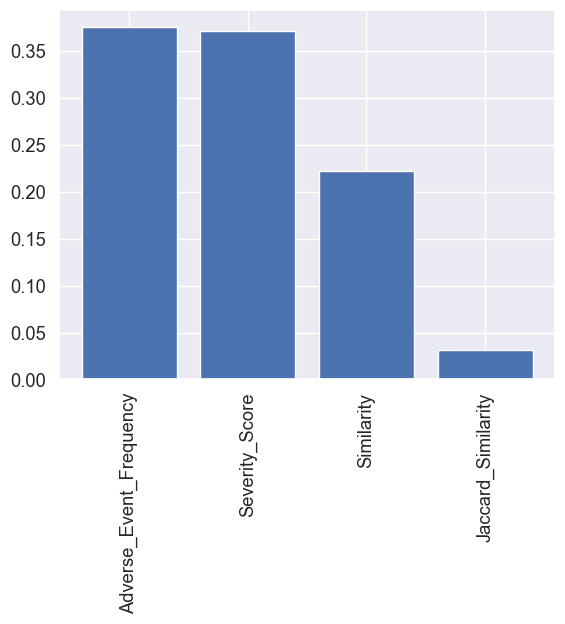

In [676]:
# check feature importance
feature_importances = best_rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.show()

Adverse Event Frequency: 0.3751
Severity Score: 0.3712
Chemical Similarity: 0.2224
Protein Target Similarity: 0.0313


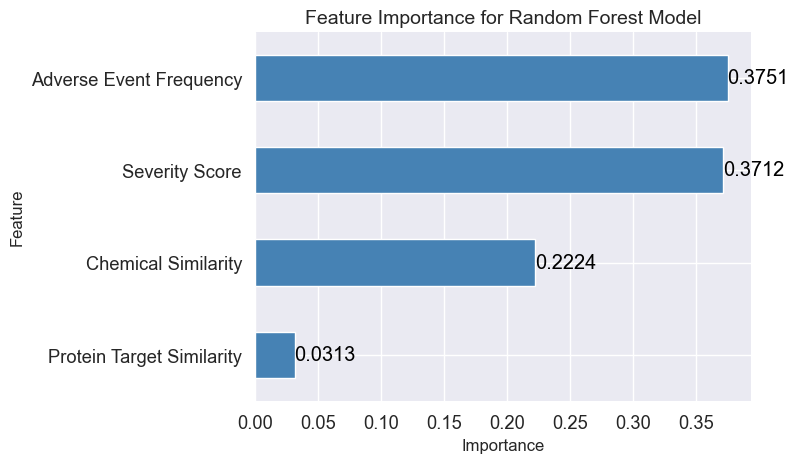

In [678]:
# plotting feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)

# dictionary to rename features
name_dict = {
    'Adverse_Event_Frequency': 'Adverse Event Frequency',
    'Severity_Score': 'Severity Score',
    'Similarity': 'Chemical Similarity',
    'Jaccard_Similarity': 'Protein Target Similarity',
}

# print out importance data weights 
for feature, importance in feature_importances.items():
    print(f'{name_dict.get(feature)}: {importance:.4f}')

# sort feature importances by importance (descending order)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# apply dictionary to y-axis labels
new_y_labels = [name_dict[col] if col in name_dict else col for col in feature_importances_sorted.index]

# plotting the top features
ax = feature_importances_sorted.plot(kind='barh', color='#4682B4')

# highest importance feature on top
plt.gca().invert_yaxis()

# set font
font = {'fontname': 'Arial'}

# add axis labels
plt.xlabel('Importance', **font, fontsize=12)
plt.ylabel('Feature', **font, fontsize=12)

# add title
ax.set_title('Feature Importance for Random Forest Model', loc='center', **font, fontsize=14)

# remove borders
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# remove y-axis ticks
ax.tick_params(axis='y', which='both', left=False)
    
# rename the y-axis labels
ax.set_yticklabels(new_y_labels)

# add data weights
for i, value in enumerate(feature_importances_sorted):
    ax.text(value, i, f'{value:.4f}', color='black', va='center')

# save as .png file
plt.savefig('feature_importance_64_calibrated.png', bbox_inches='tight')
plt.show()

[[ 270  495]
 [  53 6930]]


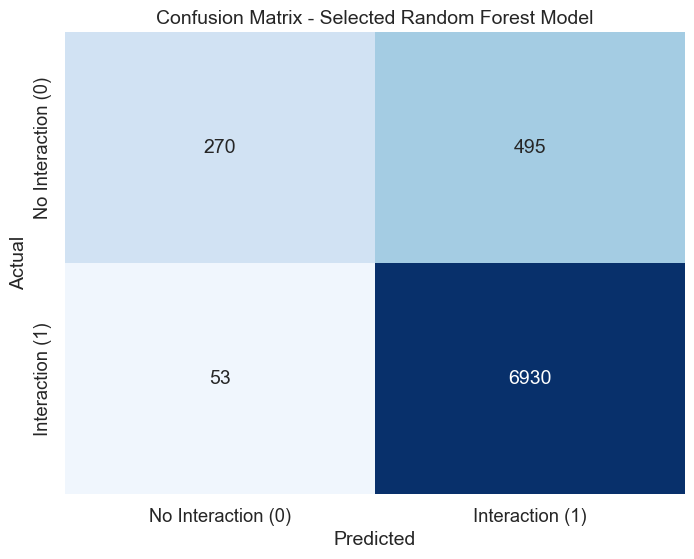

In [679]:
cm = confusion_matrix(y_test, y_pred_calibrated)
print(cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 

# plot the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Interaction (0)', 'Interaction (1)'], 
            yticklabels=['No Interaction (0)', 'Interaction (1)'], 
            annot_kws={"size": 14}, vmin=0, vmax=cm.max() * 0.2)

# add labels, title, and show the plot
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix - Selected Random Forest Model', fontsize=14)
plt.savefig('confusion_matrix_rf_64_calibrated.png')
plt.show()

In [680]:
# save the model
with open("random_forest_model_calibrated_best_params_64.pkl", "wb") as file:
    pickle.dump(calibrated_rf, file)
print("model saved as 'random_forest_model_calibrated_best_params_64.pkl'")

model saved as 'random_forest_model_calibrated_best_params_64.pkl'


## Predicitng interactions between OTC-prescription drug pairs using best RF model

In [687]:
# load rf model
with open("random_forest_model_calibrated_best_params_64.pkl", "rb") as file:
    rf_model = pickle.load(file)

In [688]:
# load file with all drug pairs 
candidate_drug_pairs_df = pd.read_csv('ddinter_with_features.csv')

# extract feature columns used for training
feature_columns = ['Adverse_Event_Frequency', 'Severity_Score', 'Similarity','Jaccard_Similarity']

# generate probability predictions
probability_predictions = rf_model.predict_proba(candidate_drug_pairs_df[feature_columns])[:, 1]  # probability of class 1

# add probabilities to the df
candidate_drug_pairs_df["Interaction_Probability"] = probability_predictions

# print results
print(candidate_drug_pairs_df[["Drug_Name_1", "Drug_Name_2", "Interaction_Probability"]])

# save to csv
candidate_drug_pairs_df.to_csv('prediction_scores_calibrated_64_bestparams.csv', index=False)

               Drug_Name_1    Drug_Name_2  Interaction_Probability
0                 Abacavir  Acetaminophen                 0.917273
1                 Abacavir      Ibuprofen                 0.941545
2                 Abacavir       Naproxen                 0.938332
3                 Abacavir     Azelastine                 0.939827
4                 Abacavir    Alcaftadine                 0.941582
...                    ...            ...                      ...
74849  Methylphenobarbital     Mometasone                 0.941266
74850  Methylphenobarbital      Ketotifen                 0.941996
74851  Methylphenobarbital      Docosanol                 0.927013
74852  Methylphenobarbital    Terbinafine                 0.939391
74853  Methylphenobarbital   Clotrimazole                 0.942308

[74854 rows x 3 columns]


In [689]:
# load the csv with drug pair probabilities
df = pd.read_csv('prediction_scores_calibrated_64_bestparams.csv')

# define probability bins
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# bin probabilities into ranges
df['Probability_Range'] = pd.cut(df['Interaction_Probability'], bins=bins, labels=labels, include_lowest=True)

# count the number of drug pairs in each range
counts = df['Probability_Range'].value_counts().sort_index()
print(counts)

Probability_Range
0-0.1        518
0.1-0.2     1115
0.2-0.3      300
0.3-0.4       78
0.4-0.5      185
0.5-0.6      346
0.6-0.7       60
0.7-0.8      153
0.8-0.9     2878
0.9-1.0    69221
Name: count, dtype: int64
